In [1]:
# fraud_analysis.ipynb

"""
Fraud Detection Notebook
------------------------

This notebook connects to a local Neo4j database,
runs fraud detection Cypher queries (IRSF, Wangiri, SIM Box),
and visualizes the results using Pandas and Matplotlib.

Make sure Neo4j is running (docker-compose up),
and CSVs are loaded with load_cypher scripts.
"""

from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1. Connect to Neo4j
# ----------------------------
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "demoPassword123"))

In [2]:
def run_query(query: str) -> pd.DataFrame:
    """Helper to run Cypher query and return Pandas DataFrame."""
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.data() for r in result])


Top Premium Numbers (IRSF):


,caller,premiumNumber,callVolume,totalCost
0,+1814005450,+27397542448,6,83.321
1,+1873237671,+8828578037,7,69.565
2,+1221926600,+27397542448,6,67.081
3,+1597149931,+9799490111,5,61.491
4,+1221926600,+8828578037,7,56.354
5,+1124623359,+44995108037,4,53.371
6,+1026224160,+8828578037,5,52.788
7,+1775601223,+8828578037,5,51.713
8,+1571480507,+9799490111,4,49.888
9,+1293802269,+27397542448,4,49.059


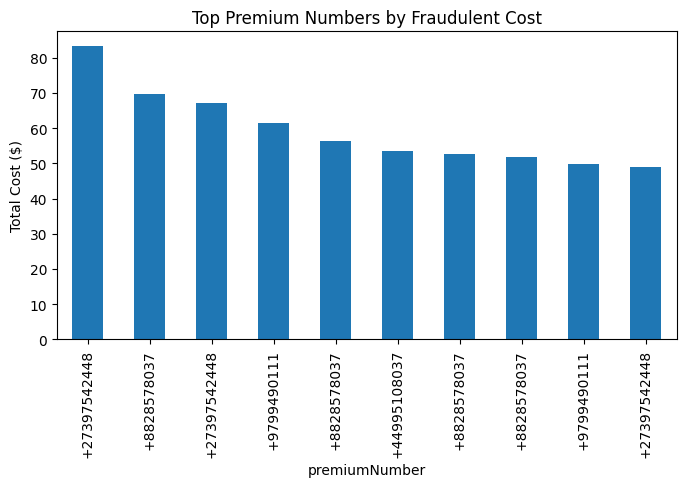

In [5]:
# ----------------------------
# 2. IRSF Detection
# Goal: Identify top callers generating traffic to premium destinations (IRSF pattern)
# Context: Fraudsters generate artificial traffic to high-cost premium-rate numbers (e.g., +882, +979, +44-9xxx).
# Carriers are left with inflated bills — a hallmark of International Revenue Share Fraud.
#
# SQL Way:
# SELECT caller, callee, COUNT(*) AS call_volume, SUM(cost) AS total_cost
# FROM cdrs
# WHERE callee_country = 'PREMIUM'
# GROUP BY caller, callee
# ORDER BY total_cost DESC
# LIMIT 10;
# ----------------------------
irsf_query = """
MATCH (n:PhoneNumber)-[c:CALLS]->(p:PhoneNumber)
WHERE c.callee_country = "PREMIUM"
RETURN 
        n.number AS caller,
        p.number AS premiumNumber,
        count(c) AS callVolume,
        sum(c.cost) AS totalCost
ORDER BY totalCost DESC
LIMIT 10
"""

df_irsf = run_query(irsf_query)
print("Top Premium Numbers (IRSF):")
display(df_irsf)

if df_irsf.empty:
    print("No IRSF fraud detected in dataset.")
else:
    df_irsf.plot(kind="bar", x="premiumNumber", y="totalCost", legend=False,
                 title="Top Premium Numbers by Fraudulent Cost", figsize=(8,4))
    plt.ylabel("Total Cost ($)")
    plt.show()


Top Suspicious Wangiri Callers:


,suspiciousCaller,attempts,victims
0,+4951733564,9,"[+1994954670, +1201131692, +1672115526, +19901..."
1,+4424146573,8,"[+1172282824, +1298229437, +1511947643, +19817..."
2,+3384779822,7,"[+1160575046, +1170715377, +1438266860, +16370..."
3,+4482551511,7,"[+1163119785, +1162060546, +1371901750, +18031..."
4,+9132580555,6,"[+1461042543, +1733485937, +1940091347, +15242..."
5,+9176093866,6,"[+1994954670, +1195475598, +1940091347, +18412..."
6,+3332006205,6,"[+1278721273, +1346922426, +1995226582, +18414..."
7,+4988105918,6,"[+1625792787, +1176955680, +1195475598, +11233..."
8,+3325261984,6,"[+1246059658, +1576038028, +1076493014, +16164..."
9,+4443026973,6,"[+1900915052, +1171418459, +1146780827, +12755..."


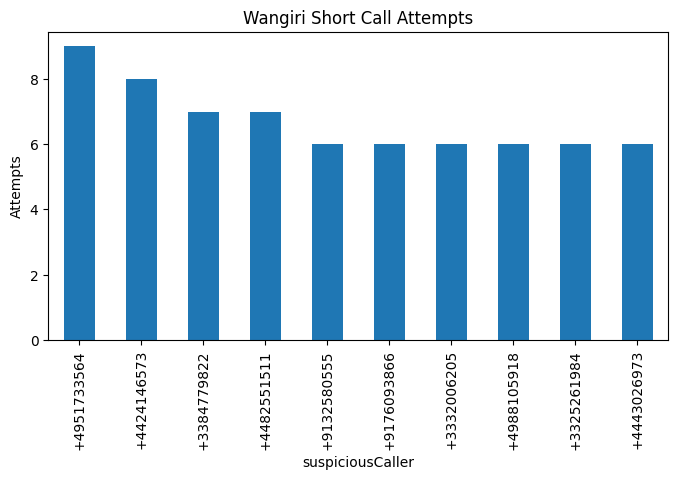

In [7]:
# ----------------------------
# 3. Wangiri Detection
# ----------------------------
wangiri_query = """
MATCH (a:PhoneNumber)-[c:CALLS]->(b:PhoneNumber)
WHERE c.duration <= 3 AND c.caller_country = "INTL"
RETURN a.number AS suspiciousCaller,
       count(c) AS attempts,
       collect(DISTINCT b.number)[0..10] AS victims
ORDER BY attempts DESC
LIMIT 10
"""

df_wangiri = run_query(wangiri_query)
print("Top Suspicious Wangiri Callers:")
display(df_wangiri)

if df_wangiri.empty:
    print("No Wangiri fraud detected in dataset.")
else:
    # Plot
    df_wangiri.plot(kind="bar", x="suspiciousCaller", y="attempts", legend=False,
                    title="Wangiri Short Call Attempts", figsize=(8,4))
    plt.ylabel("Attempts")
    plt.show()



Suspicious SIM Box Devices:


,suspiciousDevice,numberCount
0,SIMBOX_IMEI_1,90
1,SIMBOX_IMEI_4,90
2,SIMBOX_IMEI_3,90
3,SIMBOX_IMEI_2,90


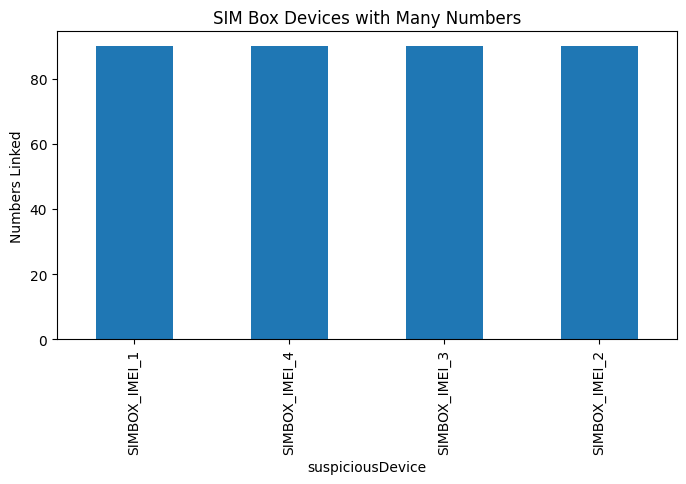

In [8]:
# ----------------------------
# 4. SIM Box Detection
# ----------------------------
simbox_query = """
MATCH (d:Device)<-[:USES]-(n:PhoneNumber)
WITH d, count(DISTINCT n) AS numberCount
WHERE numberCount >= 50
RETURN d.imei AS suspiciousDevice, numberCount
ORDER BY numberCount DESC
LIMIT 10
"""

df_simbox = run_query(simbox_query)
print("Suspicious SIM Box Devices:")
display(df_simbox)

if df_simbox.empty:
    print("No Simbox fraud detected in dataset.")
else:
    # Plot
    df_simbox.plot(kind="bar", x="suspiciousDevice", y="numberCount", legend=False,
                   title="SIM Box Devices with Many Numbers", figsize=(8,4))
    plt.ylabel("Numbers Linked")
    plt.show()

In [9]:
# ----------------------------
# Done
# ----------------------------
driver.close()